## Part 2: Finetuning pretrained CNN on the downstream task
In this part, you will finetune a pretrained CNN model to another task. Finetuning is powerful with the following strengths:
1. **Faster training** : It starts with pre-trained weights which allow the model to converge faster than training from scratch.
2. **Domain Adaptation** : Fine-tuning is effective for adapting a model trained on one domain to another.
3. **Transfer Learning**...and more

In this part, you will finetune on BDD weather classifcation dataset, more details here: https://www.kaggle.com/datasets/marquis03/bdd100k-weather-classification

### Tasks
1. Follow the steps and complete your finetuning procedure
2. Compare the training/val loss/accuracy curve between training from scratch and finetuning
3. Plot the confusion matrix for two cases

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch import Tensor
from typing import Type
from torchvision.datasets import ImageFolder

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import pdb

import kagglehub

### [0 points] Step 1: Download the BDD100K weather classification dataset from Kaggle
Please DO NOT modify this cell.

In [2]:
# Download BDD weather classification dataset
base_dir = kagglehub.dataset_download("marquis03/bdd100k-weather-classification")
print("Path to dataset files:", base_dir)
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'val')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Path to dataset files: /home/saijaideepreddymure/.cache/kagglehub/datasets/marquis03/bdd100k-weather-classification/versions/1


### [5 points] Step 2: Create the data loader, and split it to train/val

Basically this step is the same as you did in Part 1.
Remember to change the ```num_classes``` to 7, and we will only train for 10 epochs.

1. The original folder structure is: \
   ├── train \
│   ├── labels (such as clear, foggy...) \
│   │   ├── *****.jpg \
│   │   ├── *****.jpg \
│   │   ├── ... \
   It is highly recommended to use ```dataset.ImageFolder``` to load the data!
2. To check how to transform your data, check here: https://pytorch.org/vision/main/transforms.html
3. Later when you train the model, you might need to tune hyperparameters. For example, you may not want the fixed learning rate.


In [3]:
image_size = 64
learning_rate = 0.01
batch_size = 32
num_epochs =10
num_classes = 7 

train_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
])

train_data = ImageFolder(root = train_dir,transform = train_transforms)
test_data = ImageFolder(root = test_dir,transform = test_transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data,[train_size,val_size])


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


### [5 points] Step 3: Copy your CNN model and training function in Part 1 after this cell

In [4]:
import torch
import torch.nn as nn

class yourCNN(nn.Module):
    def __init__(self, num_classes=200):
        super(yourCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global pooling
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

 


In [5]:
model = yourCNN(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### [15 points] Step 4: Compare the difference of finetuning from pretrained model and training from scratch
1. You will need to finetune two models. The first is the model trained from scratch with the BDD dataset, and another is finetuning from pretrained model.
2. For training from scratch, it is almost the same procedure as in Part 1, but the dataset changes.
3. For finetuning, the procedure is:
   * Initialize the model and load the pretrained model using ```torch.load()```, remember that we saved the trained model in Part 1!
   * The output of original CNN is 200 classes, you might need to reinitialize the model to output 7 classes by replacing the last fc layer
   * More details : https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [6]:
### Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        #############################################################
        #                      Your code here                       #
        #############################################################
        train_loss = 0.0
        train_accuracy = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_accuracy += (predicted == labels).sum().item() / len(labels) # Calculate accuracy for the batch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy/len(train_loader):.4f}")

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy / len(train_loader)) # Store average batch accuracy



        ### Validation
        model.eval()
        #############################################################
        #                      Your code here                       #
        #############################################################
        val_loss = 0.0
        val_accuracy = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_accuracy += (predicted == labels).sum().item() / len(labels) # Calculate accuracy for the batch

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy / len(val_loader)) # Store average batch accuracy
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy/len(val_loader):.4f}")


    return train_losses, val_losses, train_accuracies, val_accuracies, model

Epoch 1/10, Loss: 1.3286, Accuracy: 0.5476
Epoch 1/10, Validation Loss: 1.2133, Validation Accuracy: 0.5336
Epoch 2/10, Loss: 1.1978, Accuracy: 0.5878
Epoch 2/10, Validation Loss: 1.5225, Validation Accuracy: 0.5336
Epoch 3/10, Loss: 1.1827, Accuracy: 0.5920
Epoch 3/10, Validation Loss: 1.1721, Validation Accuracy: 0.6094
Epoch 4/10, Loss: 1.1792, Accuracy: 0.5900
Epoch 4/10, Validation Loss: 1.1421, Validation Accuracy: 0.5852
Epoch 5/10, Loss: 1.1646, Accuracy: 0.5940
Epoch 5/10, Validation Loss: 1.1147, Validation Accuracy: 0.6044
Epoch 6/10, Loss: 1.1567, Accuracy: 0.5996
Epoch 6/10, Validation Loss: 1.1294, Validation Accuracy: 0.6017
Epoch 7/10, Loss: 1.1402, Accuracy: 0.6064
Epoch 7/10, Validation Loss: 1.0612, Validation Accuracy: 0.6527
Epoch 8/10, Loss: 1.1230, Accuracy: 0.6219
Epoch 8/10, Validation Loss: 1.1095, Validation Accuracy: 0.6205
Epoch 9/10, Loss: 1.1088, Accuracy: 0.6269
Epoch 9/10, Validation Loss: 1.0676, Validation Accuracy: 0.6573
Epoch 10/10, Loss: 1.1072, A

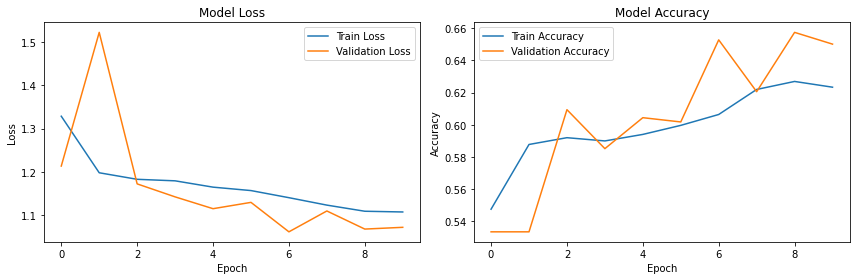

In [7]:
### Train the model
train_losses, val_losses, train_accuracies, val_accuracies, model = train_model(model, train_loader, val_loader, criterion, optimizer)

 
torch.save(model.state_dict(), 'BDD_weights_full_dataset.pth')

### Plot results. This is a naive plot, you are encouraged to improve it!
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### [0 points] Step 5: Start training the model!

In [13]:
 
model_ft = yourCNN(num_classes=200)   
model_ft.load_state_dict(torch.load("CNN_weights_full_dataset.pth"))  
in_features = model_ft.fc_layers[-1].in_features   
model_ft.fc_layers[-1] = nn.Linear(in_features, 7) 
model_ft = model_ft.to(device) 
for param in model_ft.parameters():
    param.requires_grad = True   
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)  
criterion = nn.CrossEntropyLoss() 
print(model_ft)


yourCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

Epoch 1/10, Loss: 0.9548, Accuracy: 0.6781
Epoch 1/10, Validation Loss: 0.7699, Validation Accuracy: 0.7409
Epoch 2/10, Loss: 0.7536, Accuracy: 0.7502
Epoch 2/10, Validation Loss: 0.7200, Validation Accuracy: 0.7566
Epoch 3/10, Loss: 0.6724, Accuracy: 0.7762
Epoch 3/10, Validation Loss: 0.7228, Validation Accuracy: 0.7580
Epoch 4/10, Loss: 0.5925, Accuracy: 0.7998
Epoch 4/10, Validation Loss: 0.7382, Validation Accuracy: 0.7523
Epoch 5/10, Loss: 0.4958, Accuracy: 0.8311
Epoch 5/10, Validation Loss: 0.7869, Validation Accuracy: 0.7475
Epoch 6/10, Loss: 0.3928, Accuracy: 0.8672
Epoch 6/10, Validation Loss: 0.8749, Validation Accuracy: 0.7311
Epoch 7/10, Loss: 0.2940, Accuracy: 0.9006
Epoch 7/10, Validation Loss: 0.9719, Validation Accuracy: 0.7375
Epoch 8/10, Loss: 0.2143, Accuracy: 0.9266
Epoch 8/10, Validation Loss: 1.1275, Validation Accuracy: 0.7353
Epoch 9/10, Loss: 0.1670, Accuracy: 0.9430
Epoch 9/10, Validation Loss: 1.2692, Validation Accuracy: 0.7208
Epoch 10/10, Loss: 0.1388, A

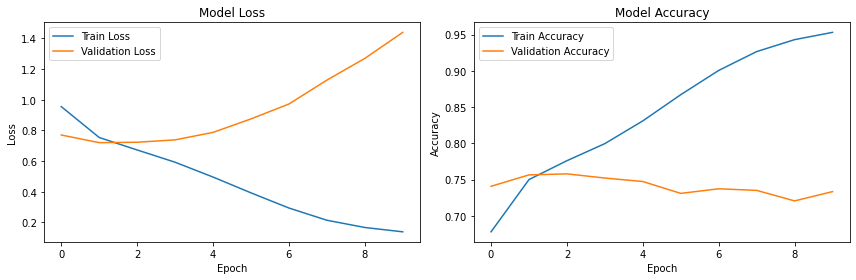

In [14]:
### Train the model
train_losses, val_losses, train_accuracies, val_accuracies, model_ft = train_model(model_ft, train_loader, val_loader, criterion, optimizer)

torch.save(model_ft.state_dict(), 'BDD_weights_full_dataset_transfer.pth')

### Plot results. This is a naive plot, you are encouraged to improve it!
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### [5 points] Step 6: Evaluate your model on testing set and plot the confusion matrix
In this part, you will learn to evaluate a trained model on testing set, and plot the confusion matrix.
Ideally, a great classification model would have non-zero values only along the diagonal, with zeros in all off-diagonal elements.

**HINTS**
1. Remember to perform the same transforms to your testing set as the validation set.
2. In ```get_predictions```, it is basically the same as you do evaluation.

In [15]:
model.load_state_dict(torch.load('BDD_weights_full_dataset.pth'))

# Change model to evaluation phase
model.eval()

# Function to get predictions and true labels
def get_predictions(model, dataloader):
    #############################################################
    #                      Your code here                       #
    #############################################################
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels)


### Get predictions and true labels
print(f"Test dataset size: {len(test_loader.dataset)}")

predictions, true_labels = get_predictions(model, test_loader)
print("Predictions:", predictions)
print("True labels:", true_labels)
 
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)
#############################################################

### Calculate accuracy
accuracy = (predictions == true_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

Test dataset size: 10000


Predictions: [0 0 6 ... 6 6 6]
True labels: [0 0 0 ... 6 6 6]
Confusion Matrix:
[[5064    0   89    0    0    0  193]
 [   7    0    3    0    0    0    3]
 [ 154    0  460    0    0    0  625]
 [ 341    0  290    0    0    0  107]
 [ 333    0   71    0    0    0  334]
 [ 520    0   74    0    0    0  175]
 [ 170    0   16    0    0    0  971]]
Test Accuracy: 0.6495


In [16]:
 
model.load_state_dict(torch.load('BDD_weights_full_dataset_transfer.pth'))

# Change model to evaluation phase
model.eval()

 


### Get predictions and true labels
print(f"Test dataset size: {len(test_loader.dataset)}")

predictions, true_labels = get_predictions(model, test_loader)
print("Predictions:", predictions)
print("True labels:", true_labels)
################# Compute confusion matrix ##################
#############################################################
# cm = ?
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)
#############################################################

### Calculate accuracy
accuracy = (predictions == true_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

Test dataset size: 10000
Predictions: [0 0 0 ... 6 4 6]
True labels: [0 0 0 ... 6 6 6]
Confusion Matrix:
[[4716    0  118  106   73  183  150]
 [   8    0    0    0    3    0    2]
 [  74    1  743   90  100   42  189]
 [ 140    0  185  335    8   35   35]
 [ 145    0   69    2  415   53   54]
 [ 231    0   37   17   48  391   45]
 [ 138    0  143    6   73   40  757]]
Test Accuracy: 0.7357


In [17]:
 
model_ft_f = yourCNN(num_classes=200)
model_ft_f.load_state_dict(torch.load("CNN_weights_full_dataset.pth")) 
in_features = model_ft_f.fc_layers[-1].in_features   
model_ft_f.fc_layers[-1] = nn.Linear(in_features, 7) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft_f = model_ft_f.to(device) 
for param in model_ft_f.parameters():
    param.requires_grad = False 
for param in model_ft_f.fc_layers[-1].parameters():
    param.requires_grad = True  
optimizer = torch.optim.Adam(model_ft_f.parameters(), lr=0.001)   
criterion = nn.CrossEntropyLoss() 
print(model_ft_f)


yourCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

Epoch 1/10, Loss: 1.4294, Accuracy: 0.5328
Epoch 1/10, Validation Loss: 1.3448, Validation Accuracy: 0.5329
Epoch 2/10, Loss: 1.3482, Accuracy: 0.5341
Epoch 2/10, Validation Loss: 1.3136, Validation Accuracy: 0.5342
Epoch 3/10, Loss: 1.3380, Accuracy: 0.5331
Epoch 3/10, Validation Loss: 1.2954, Validation Accuracy: 0.5358
Epoch 4/10, Loss: 1.3341, Accuracy: 0.5337
Epoch 4/10, Validation Loss: 1.3009, Validation Accuracy: 0.5366
Epoch 5/10, Loss: 1.3334, Accuracy: 0.5337
Epoch 5/10, Validation Loss: 1.2959, Validation Accuracy: 0.5364
Epoch 6/10, Loss: 1.3322, Accuracy: 0.5330
Epoch 6/10, Validation Loss: 1.2834, Validation Accuracy: 0.5361
Epoch 7/10, Loss: 1.3299, Accuracy: 0.5333
Epoch 7/10, Validation Loss: 1.3040, Validation Accuracy: 0.5356
Epoch 8/10, Loss: 1.3305, Accuracy: 0.5334
Epoch 8/10, Validation Loss: 1.2968, Validation Accuracy: 0.5350
Epoch 9/10, Loss: 1.3288, Accuracy: 0.5354
Epoch 9/10, Validation Loss: 1.2900, Validation Accuracy: 0.5389
Epoch 10/10, Loss: 1.3316, A

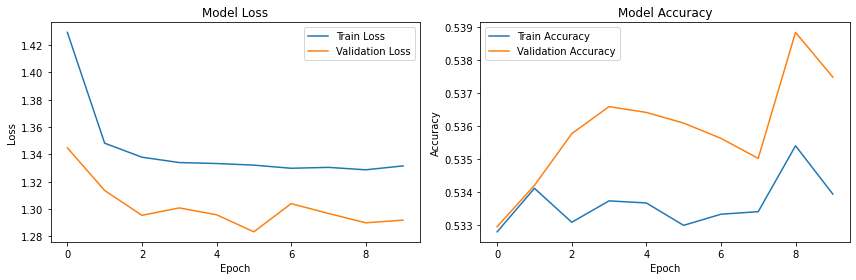

In [18]:
### Train the model
train_losses, val_losses, train_accuracies, val_accuracies, model_ft_f = train_model(model_ft_f, train_loader, val_loader, criterion, optimizer)

### We will save the model, in part 2 we gonna use it!
torch.save(model_ft_f.state_dict(), 'BDD_weights_full_dataset_transfer_lastLayer.pth')

### Plot results. This is a naive plot, you are encouraged to improve it!
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Questions
1. [5 points] What did you observe from the two approaches? Does finetuning really train faster in this case?
Sol Yes I have Observed that the fine tuning really helps a lot it made a siginificant difference in test acurracy.
2. [5 points] In the above implemetation, the whole model is finetuned to downstream task. Can we just finetune the last fc layer? That is, can we freeze all the weights except the last fc layer during training? Please implement it and analyze the performance.
Sol) We Can finetun last layer but the performance is not good an dthe accuracy is not improving which is stucking.

In [19]:
 
model.load_state_dict(torch.load('BDD_weights_full_dataset_transfer_lastLayer.pth'))

# Change model to evaluation phase
model.eval()
### Get predictions and true labels
print(f"Test dataset size: {len(test_loader.dataset)}")

predictions, true_labels = get_predictions(model, test_loader)
print("Predictions:", predictions)
print("True labels:", true_labels)
################# Compute confusion matrix ##################
#############################################################
# cm = ?
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)
#############################################################

### Calculate accuracy
accuracy = (predictions == true_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

Test dataset size: 10000


Predictions: [0 0 0 ... 0 0 0]
True labels: [0 0 0 ... 6 6 6]
Confusion Matrix:
[[5285    0   24   12    0    0   25]
 [  13    0    0    0    0    0    0]
 [1191    0   28    3    0    0   17]
 [ 720    0   10    5    0    0    3]
 [ 715    0   13    0    0    0   10]
 [ 754    0    2    1    0    0   12]
 [1109    0   10    0    0    0   38]]
Test Accuracy: 0.5356
